In [87]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import importlib
from modules import base_model as bm 
from modules import obstacles as obs
from modules import run_simulation
from modules import attractor as att
#from modules import attract

importlib.reload(bm); importlib.reload(obs); importlib.reload(run_simulation); importlib.reload(att)

print(f'Imported modules successfully!')

ImportError: cannot import name 'run_simulation' from 'modules' (unknown location)

**Attractor** \
We are considering adding a global attractor for 2 reasons. 
1. Migratory patterns are realistic. Currently initialisation and then flocking are the only deciders in where the birds go. It is more relaistic that the are heading towards something.
Birds aren't generally out for a leisurely stroll I assume. 
2. Currently when a bird hits an obstacle they 'bounce back' and go the opposite way. This isn't realistic. Birds should veer around the object. We think that if there is a global attractor which is strong enough, the birds will be forced to veer due to this attraction. I hope. \

There seems to be 2 types of attractors I can find.
1. Follow the leader. Birds follow a $p_l$ leader. However, I don't think this is what we want. We want a specific attractor.
2. Mouse. For example (https://medium.com/@issacroy05/boids-simulating-flocks-e11c121a35cc), birds see a mouse and go towards that. Hopefully we can extend this from a position to a range, or have the position be much further away.


In [ ]:
# IDENTICAL to that in toy_problem.ipynb.
# v0, eta, L, dt, Nt, N.
model_params = [0.3, 0.6, 10, 0.2, 200, 100]

# lam_c, lam_a, lam_m, lam_att, A, R.
strength_params = [0.2, 0.8, 0.4, 0.2, 0.15, 1.25]

# obstacle_params = [lam_o, x_obs, y_obs, O]
obstacle_params = [[2, 5, 5, 1.5], [1, 2, 8, 1.5], [1, 8, 2, 1.5]]

**Changes** \
See the file `attractor.py`. Similar to what Fred did, I have added a python file which shows the code for the attractor 'rule'.
This is like the previous rules, it returns a velocity. This velocity is added to the position with the other rules at each step.
I have updated the step function to include this. Docstrings and comments explain the code and changes. 

Main thoughts: 
1. Attractor does not have to be in the grid, say 10x10. It can be at (x, y) = (30, 30) for example. I need to test, but I assume if it's very far away it would act like migration and look as though the birds are going towards an area rather than a single point. 
2. If the strength is high ($\lambda_{att}$), it overwrites the obstacle propulsion and just cuts straight through. Obviously a big issue. Keep factor below ~0.2.

I have also played around with the initialisation of birds. We can have them start in a specified area, as I have done. Code can obviously be improved to include it as an input argument.
My codespace is making it very hard to make changes with module errors.

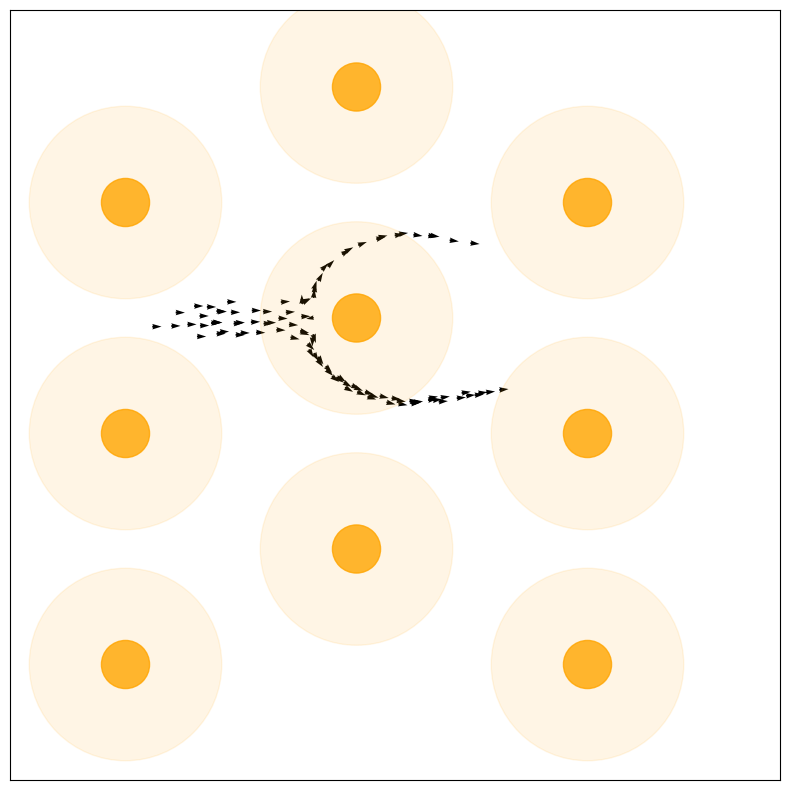

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [ ]:
# As many obstacle params as we can without overlapping
lam_o = 1
O_rad = 1.25

obstacle_params = [
 [lam_o, 1.5, 1.5, O_rad],
 [lam_o, 1.5, 4.5, O_rad],
 [lam_o, 1.5, 7.5, O_rad],

 [lam_o, 4.5, 3.0, O_rad],
 [lam_o, 4.5, 6.0, O_rad],
 [lam_o, 4.5, 9.0, O_rad],

 [lam_o, 7.5, 1.5, O_rad],
 [lam_o, 7.5, 4.5, O_rad],
 [lam_o, 7.5, 7.5, O_rad]
]

run_simulation.plot_simulation_att(model_params, strength_params, obstacle_params, [15, 6])

We want to try add a global attractor

### Notes for Colm, from Fred
Have changed the initialisation in `base_model.py` to depend on $L$ again. By default it now initialises birds within the bottom-left quadrant $(L/4)$.

Have changed all functions to now depend on obstacles as a list of obstacle parameters (a list of lists). If it's just one obstacle, you should still be able to pass it just one single list. 

Changed the plotting function very slightly by adding `add_obstacle()`, feel free (anyone) to change the way the obstacles look.

**Conerns.** This was suggested by Reynolds in the first place and is a big reason we will (possibly) use 'steer-to-avoid'; currently, if the birds approach an obstacle at a direct angle, they will not alter their velocity until very late. You can see this in the simulation above towards the end. That being said, if they aren't coming at it completely straight, it works really well.

Is `attract.py` redundant now or is it there for some other reason?

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import importlib
from modules import base_model as bm 
from modules import obstacles as obs
from modules import simulate as sim
#from modules import attractor as att
from modules import Testing as test


importlib.reload(bm); importlib.reload(obs); importlib.reload(sim);  importlib.reload(test)

print(f'Imported modules successfully!')

Imported modules successfully!


**Time Testing** \
See the three functions in `Testing.py`. \
Initial loop is the time taken for the birds to reach an x position. i.e we set x to 10. If they pass 10 then they are removed. Count the number of steps for all birds to cross or for the loop to finish all of its iterations. \
mean_step() runs this N times and returns an average of the time taken and a success rate. success rate is the percentage of birds to make it before the loop breaks. This will be useful if we implement killing or a more robust simulation where they may not make it to the end. \
mean_time() takes the various configurations and iterats through them applying the above function. The results are printed in a simple table.

The results show a difference, but it's quite minimal. I'll have to play around with parameters a bit. I think the location of the attractor could have an effect on the various results of configs. I also think a more robust grid would be useful. I.e try it on an L = 50 with loads of obstacles

In [ ]:
# IDENTICAL to that in toy_problem.ipynb.
# v0, eta, L, dt, Nt, N.
model_params = [0.3, 0.6, 10, 0.2, 200, 100]

# lam_c, lam_a, lam_m, lam_att, A, R.
strength_params = [0.2, 0.8, 0.4, 0.2, 0.15, 1.25]

attractor_pos = [15,5] #[x, y] position of global attractor. Migration destination
goal = 9 #Goal boundary. A vertical line at x = 9 for example
obs_method = 'forcefield' #Obstacle method: 'forcefield' or 'steer2avoid'
iters = 10 #Number of loops to get average time and success rate at each configuration

configs = [
    #Our basis: No Obstacles
    [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]],
    # Linear barrier patterns
    [[1, 2, 5, 1], [1, 4, 5, 1], [1, 6, 5, 1]],  # Horizontal line
    [[1, 5, 2, 1], [1, 5, 5, 1], [1, 5, 8, 1]],  # Vertical line
    
    # Diagonal patterns
    [[1, 2, 2, 1], [1, 5, 5, 1], [1, 8, 8, 1]],  # Main diagonal
    [[1, 8, 2, 1], [1, 5, 5, 1], [1, 2, 8, 1]],  # Anti-diagonal
    
    # Corner protection
    [[1, 1, 1, 1], [1, 1, 9, 1], [1, 9, 1, 1]],  # Three corners
    [[1, 9, 9, 1], [1, 1, 9, 1], [1, 9, 1, 1]],  # All corners
    
    # Central clustering
    [[1, 4, 4, 1], [1, 5, 5, 1], [1, 6, 6, 1]],  # Tight cluster
    [[1, 3, 3, 1], [1, 5, 7, 1], [1, 7, 3, 1]],  # Spread but balanced
]

wind_params = [True, 0, 0.5, False, 0, 0]

key = [
    "No Obstacles",
    "Horizontal line",
    "Vertical line",
    "Main diagonal",
    "Anti-diagonal",
    "Three corners",
    "All corners",
    "Tight cluster",
    "Spread but balanced"
]

test. mean_times(model_params, strength_params, configs, obs_method, attractor_pos, wind_params, goal, iters, key, seed = None)




| Configuration        | Average Time    | Success Rate    |
| -------------------- | --------------- | --------------- |
| No Obstacles         | 80.10           | 100.00          |
| Horizontal line      | 79.80           | 100.00          |
| Vertical line        | 82.10           | 100.00          |
| Main diagonal        | 81.10           | 100.00          |
| Anti-diagonal        | 80.40           | 100.00          |
| Three corners        | 82.70           | 100.00          |
| All corners          | 79.40           | 100.00          |
| Tight cluster        | 86.20           | 100.00          |
| Spread but balanced  | 85.20           | 100.00          |


**Final Results work** \
Implement Cathal's obstacles and larger grid. \
I have changed parameters such as goal and attractor to fit the new grid. \
Some functions have been updated to include wind and to use the most up to date functions like `simulate.step` \
I set the iterations to **1** to test for a working function. The goal is to implemet deflections into the results. I also want to use `steer2avoid` rather than `forcefield`, provided the comp time isn't significantly different. \
Once this works, I want to look at wind. Finding some wind parameters that are aggresive and moderate


In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import importlib
from modules import base_model as bm 
from modules import obstacles as obs
from modules import simulate as sim
#from modules import attractor as att
from modules import Testing as test


importlib.reload(bm); importlib.reload(obs); importlib.reload(sim);  importlib.reload(test)

print(f'Imported modules successfully!')

Imported modules successfully!


**Wind**
Once I was happy with the functions and all erros cleared, I looked at wind. \
Fist point is directional wind is hard to figure out which angle is best and it seems much less impactful then drift. If I increase lambda to 100 for example, with the best angle I found, there is no difference ve lambda = 1. It stays at 92 steps which is not the max. \
I decided to only consider drift as I had much more conmtrol/flexability with it. \
Through Trial and error I found that 84 is the max steps for this `benchmark`. I assume it is max velocity that is forcing this limit.


In [ ]:
#Standardise and vary wind now that I'm happy ish

#[Wind drift on/off, drift x component, drift y component,
#directional wind on/off, wind angle, assuming [0, 2pi], wind strength

#After some test the directional wind seems insignificant and I can't find an angle where increasing the strenght makes a difference
#Max speed seems to come into play and 84 steps is the fastest possible time
#92 ia benchmark with 0 wind, 84 seems to be max so look for smallest x wind component for 88 and 84
#Maybe worth normalising around this
wind_params = [True, 41, 0, False, np.pi / 2, 100]
test.mean_steps(model_params, strength_params, configs_2[0], obs_method, attractor_pos, wind_params, goal, 1, 10)

(85.0, np.float64(100.0), 0)

**Final Results** \
I picked three wind types. No wind, moderate and aggressive.
The benchmark for these paramters is 92 steps. The max seems to be 84. I set moderate wind so that it would be 88 steps. When I say benchmark I mean no obstacles, all things controlled. \
I made a list of names and looped through as titles for each table. \
All other parameters were taken from Cathal. \
I named the configurations. \
 The goal(x = 33) is one in from the boundary(x = 34). \
The attractor is set in the middle, just past the boundary (35, 17) \
I ran 10 iterations for the final results. It took a while. Iterations refer to the number of times we count the steps and then take the average
Only run 1 iterations if you are testing anything 

Sine Wave seems to be the best. I think we need to see the layouts for more information. \
I also think reducing the wind is a good idea. The aggresive wind is too aggresive and all results are too similar


In [18]:
wind_params = [
    [False, 0, 0, False, np.pi / 2, 100],
    [True, 5, -5, False, np.pi / 2, 100],
    [True, -5, 5, False, np.pi / 2, 100]
]

names = [
    'No Wind',
    'Tailwind',
    'HeadWind'
]

L=36
# v0, eta, L, dt, Nt, N.
model_params = [0.9, 0.5, L, 0.2, 200, 100]

# lam_c, lam_a, lam_m, lam_att A, R.
strength_params = [0.2, 0.8, 0.4, 0.2, 0.15, 1.25]

# Test different obstacle configurations
attractor_pos = [100, 18] #[x, y] position of global attractor. Migration destination
goal = 35 #Goal boundary. A vertical line at x = 9 for example
obs_method = 'steer2avoid' #Obstacle method: 'forcefield' or 'steer2avoid'
iters = 15

configs_2 = [
    # Various barrier configurations (each with 16 obstacles)
    [[0, 0, 0, 0]], #No Obstacles
    [[10, x, y, 4] for x in range(2, L, 4) for y in [L/3, 2*L/3]],
    (
        [[10, x, L/3 + 2 * np.sin(x), 4] for x in range(2, L, 4)] + # Wave 1 (1/3 up)
        [[10, x, 2*L/3 + 2 * np.sin(x), 4] for x in range(2, L, 4)]   # Wave 2 (2/3 up)
    ),  # Horizontal line
    #[[5, x, 2*np.sin(x) + 17, 3] for x in range(2, L, 4)], # sine wave
    
    # Vertical line
    [[10, x, y, 4] for x in [L/3, 2*L/3] for y in range(2, L, 4)],
    
    # Diagonal barriers
    (
    [[10, x, x, 4] for x in range(2, L, 4)] +
    [[10, x, L - x, 4] for x in range(2, L, 4)] # Main diagonal
    ),
    # 4x4 grid pattern (16 obstacles)
    [[10, x, y, 4] for x in [9, 18, 27] for y in [5.5, 10.5, 15.5, 20.5, 25.5, 30.5]], # 4x4 grid
    
    # Random configuration with spacing (16 obstacles)
    [[10, random.randint(2, L-2), random.randint(2, L-2), 4] for _ in range(18)]
]


key = [
    "No Obstacles",
    "Horizontal lines",
    "Sine Waves",
    "Vertical Lines",
    "Cross",
    "3x6 Grid",
    "Random Configuration"
]

#test.mean_steps(model_params, strength_params, configs_2[1], obs_method, attractor_pos, wind_params[2], goal, 1, seed = 10, init_left = True)

for i, wind_param in enumerate(wind_params):
        title = names[i]
        print(f'Iteration: {title}')
        print(f'{"-"*83}')
        test.mean_times(model_params, strength_params, configs_2, obs_method, 
                        attractor_pos, wind_param, goal, iters, key, seed = None)
        print()

Iteration: No Wind
-----------------------------------------------------------------------------------
| Configuration        | Average Time    | Success Rate    | Average Deflections  |
| -------------------- | --------------- | --------------- | -------------------- |
| No Obstacles         | 57.60           | 100.00          | 0.00                 |
| Horizontal lines     | 57.53           | 100.00          | 4160.87              |
| Sine Waves           | 59.20           | 100.00          | 3991.27              |
| Vertical Lines       | 58.13           | 100.00          | 4076.53              |
| Cross                | 58.27           | 100.00          | 3893.40              |
| 3x6 Grid             | 59.47           | 100.00          | 4744.07              |
| Random Configuration | 58.13           | 100.00          | 3841.53              |

Iteration: Tailwind
-----------------------------------------------------------------------------------
| Configuration        | Average Tim

**Limitations** \
Some limitations came up. We can consider including them in the report maybe.
1. Wind doesn't seem to have much of an effect at this velocity. From whati can tell, the max velocity overwrites everything else.
2. Issues with avoiding obstacles when obstacle size is large. \
    If we run simulations and visualise some of these configs, some birds fly right through obsatcles. I have tested it for a huge lambda_o. I think they are considering multiple obsatcles in sight and are being forced to stay on their trajectory. \
    We need large obstacles for clear testing results, but that creates more issues.
3. Max velocity seems may be too strong. This is obviously a formula rather than an arbitrary figure, so not our issue, but something to consider as a talking point.
4. Scaling issues. We can say that with larger grids, parameters vary and it seems like max velocity plays a large role. I.e over a larger distance of simulation, the conclusions are different. This can be a talking point.

**Results** \
*I think I will change the velocity which I'm hoping will give more variation with wind, but the results and conclusion below still stand. \
*I may change wind. We could have adverse wind blowing them back.
Horizontal lines seem to be best. This is some what intuative. From running a few simualtions and seeing the others it seems to be related to having long clear lines of travel. \
The test is considering the steps until all birds have crossed (or run out of iterations). So it's steps until the last bird get's through. When a bird deflects, a lagging bird aprticularly, they have to catch up. I think due to flocks matching velocities or the velocity being limited, the lagging bird has time to catch up if they have a clear path of travel. \
This is why horizontal lines seem to be the best. A bird deflects in the beginning and falls back, but has time to catch up because once it deflects from an obstacle it has a clear path to the end. \
With this logic in mind, we assume the configurations with many obstructed paths would perform worst, and they do. Sine, cross and random seem worst. Visualising these, it is clear that there are very little consistently clear paths for large groups of birds. There will be many deflections holding back the groups and creating these lags in flocks/birds. \

**Outlook** \
Express the above in results I assume. For conclusion, consider what this means for WHWF. 
1. They need to understand bird migratory patterns specific to them. Here we can reference real world data related to migratory patterns. \
2. Turbines should align with the direction of travel. Spaced consistently and as large as possible between each row. Ideally this would cover migratory patterns year round. Hopefully, they go the opposite way each time around.
3. So, if we consider a gird. And we hav ebirds travelling west to east (left to right), the ideal layout would be maximising th enumber of turbins within a horizontal row and extending the rows as far a possible. This is to say we want to lowest number of horizontal rows to create the largest space between rows. The number of turbines in the row and the length of row is insignificant as once the flock deflects and has a clear path, it will speed up to its max/comfortable speed and chill there. It will make up time and then relax


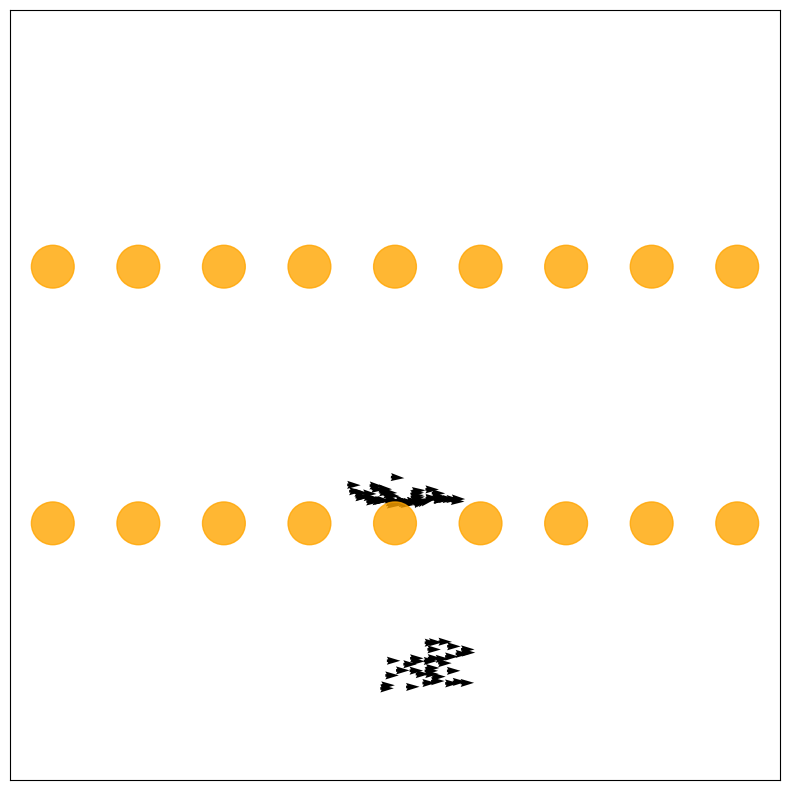

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [17]:


sim.plot_simulation(model_params, strength_params, configs_2[1], wind_params[1], attractor_pos, 
                        init_left = True, obs_method = 'steer2avoid', fig = None, ax = None, 
                        seed = 10, save = False)

In [6]:
test.mean_steps(model_params, strength_params, configs_2[0], obs_method, attractor_pos, wind_params[2], goal, 1, seed = 10, init_left = True)


(117.0, np.float64(100.0), 0.0)